In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import codecs

# UD_Dutch
data_dir1 = '/home/jvdzwaan/data/UD_Dutch/'
test1 = data_dir1 + 'nl-ud-test.conllu'
train1 = data_dir1 + 'nl-ud-train.conllu'

# UD_Dutch_LassySmall
data_dir2 = '/home/jvdzwaan/data/UD_Dutch-LassySmall/'
test2 = data_dir2 + 'nl_lassysmall-ud-test.conllu'
train2 = data_dir2 + 'nl_lassysmall-ud-train.conllu'

In [3]:
import os

def create_dirs(fname):
    """Create (output) directories if they don't exist
    """
    if not os.path.exists(fname):
        os.makedirs(fname)

out_dir = '/home/jvdzwaan/data/tmp/sherlock/spaCy/'
out_dirs = [out_dir, os.path.join(out_dir, 'vocab/'), os.path.join(out_dir, 'pos/')]

for o in out_dirs:
    print o
    create_dirs(o)

/home/jvdzwaan/data/tmp/sherlock/spaCy/
/home/jvdzwaan/data/tmp/sherlock/spaCy/vocab/
/home/jvdzwaan/data/tmp/sherlock/spaCy/pos/


In [4]:
def get_sentence(data):
    words = []
    tags = []
    parts = data.split('\n')
    if parts:
        for part in parts:
            if not part.startswith('#'):
                d = part.split()
                if len(d) > 3:
                    words.append(d[1])
                    tags.append(d[3])
                
    return words, tags
    

def read_connl(filepath):
    with codecs.open(filepath, encoding='utf-8') as f:
        data = f.read()
        
    sentences = data.split('\n\n')
    for sentence in sentences:
        yield get_sentence(sentence)

In [5]:
# create tag map and data
import json
import codecs

tags = set()
data = []
for train in (train1, train2):
    for w, t in read_connl(train):
        tags.update(t)
        data.append((w,t))

tag_map = {}    
for t in tags:
    tag_map[t] = {'pos': t}
print tag_map

with codecs.open(os.path.join(out_dir, 'vocab', 'tag_map.json'), 'wb', encoding='utf-8') as f:
    json.dump(tag_map, f, indent=2, encoding='utf-8')

print len(data)

{u'ADV': {'pos': u'ADV'}, u'NOUN': {'pos': u'NOUN'}, u'ADP': {'pos': u'ADP'}, u'PRON': {'pos': u'PRON'}, u'SCONJ': {'pos': u'SCONJ'}, u'PROPN': {'pos': u'PROPN'}, u'DET': {'pos': u'DET'}, u'SYM': {'pos': u'SYM'}, u'INTJ': {'pos': u'INTJ'}, u'PART': {'pos': u'PART'}, u'PUNCT': {'pos': u'PUNCT'}, u'NUM': {'pos': u'NUM'}, u'AUX': {'pos': u'AUX'}, u'X': {'pos': u'X'}, u'CONJ': {'pos': u'CONJ'}, u'ADJ': {'pos': u'ADJ'}, u'VERB': {'pos': u'VERB'}}
19643


In [6]:
import spacy

def get_accuarcy(vocab, tagger, filepaths_test):
    docs_test = []
    tags_test = []
    scorer = spacy.scorer.Scorer()
    for filepath_test in filepaths_test:
        for w,t in read_connl(filepath_test):
            doc = spacy.tokens.Doc(vocab, words=w)
            tagger(doc)
            gold = GoldParse(doc, tags=t, entities=['O']*len(t), deps=['']*len(doc))
            docs_test.append(doc)
            tags_test.append(t)
            scorer.score(doc, gold, verbose=True)
    return scorer.scores['tags_acc']

In [7]:
import spacy
from spacy.vocab import Vocab
from spacy.tagger import Tagger
from spacy.tokens import Doc
from spacy.gold import GoldParse
from spacy.language import BaseDefaults

import random

# Use empty vocabulary
#vocab = Vocab(tag_map=tag_map, lex_attr_getters=BaseDefaults.lex_attr_getters)

# Use vocabulary with Dutch data
nlp = spacy.load('nl')
vocab = nlp.vocab

tagger = Tagger(vocab)

n_iter = 50
failed_sentences = 0
sentences = 0
accuracy_test = []
accuracy_train = []

for i in range(n_iter):
    print i,
    random.shuffle(data)
    for sample in data:
        sentences += 1
            
        try:
            doc = Doc(vocab, words=sample[0])
            gold = GoldParse(doc, tags=sample[1])
            
            tagger.update(doc, gold)
        except Exception:
             failed_sentences += 1
    accuracy_test.append(get_accuarcy(vocab, tagger, [test1, test2]))
    accuracy_train.append(get_accuarcy(vocab, tagger, [train1, train2]))

print
print 'number of sentences', sentences/n_iter
print 'number of sentences that failed', failed_sentences/n_iter

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
number of sentences 19643
number of sentences that failed 798


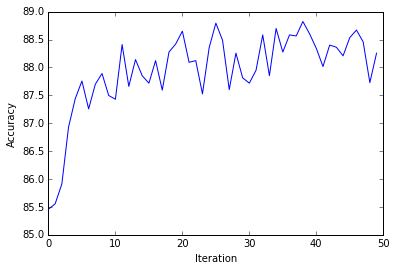

In [8]:
plt.plot(accuracy_test)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.show()

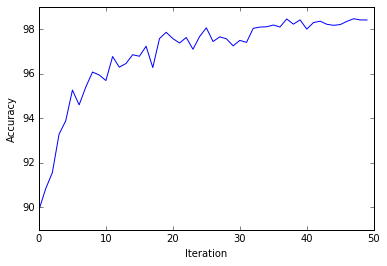

In [9]:
plt.plot(accuracy_train)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.show()

In [10]:
accuracy_test[-1]

88.25564632388276

In [11]:
print len(vocab.strings), len(vocab)

289476 246258


In [12]:
tagger.model.end_training()

In [13]:
tagger.model.dump(os.path.join(out_dirs[0], 'pos', 'model'))
#with codecs.open(os.path.join(out_dirs[0], 'vocab', 'strings.json'), 'wb', encoding='utf-8') as file_:
#    tagger.vocab.strings.dump(file_)

In [14]:
# save other relevant models (taken from spaCy/language.py end_training line 353)
from spacy.attrs import TAG
tagger_freqs = list(tagger.freqs[TAG].items())
print len(tagger_freqs)

17


In [15]:
with codecs.open(os.path.join(out_dirs[0], 'vocab', 'serializer.json'), 'wb', encoding='utf-8') as file_:
            file_.write(
                json.dumps([
                    (TAG, tagger_freqs)
                ]))